# Project 1
### *Linear Regresssion Model - Breast Cancer Prediction*

In [8]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
df = pd.read_csv('project1-data.csv')

In [3]:
df.head() # more info aobut data

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [4]:
df.info() # more info aobut data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        386 non-null    object
 1   age          386 non-null    object
 2   menopause    386 non-null    object
 3   tumor-size   385 non-null    object
 4   inv-nodes    385 non-null    object
 5   node-caps    386 non-null    object
 6   deg-malig    386 non-null    int64 
 7   breast       386 non-null    object
 8   breast-quad  386 non-null    object
 9   irradiat     386 non-null    object
dtypes: int64(1), object(9)
memory usage: 30.3+ KB


## Part 1

In [5]:
# raw data shape and size
print(f"Shape of data (rows, columns): {df.shape}")
print(f"Size of data: {df.size}")

Shape of data (rows, columns): (386, 10)
Size of data: 3860


In [6]:
# data types
print(f"Datatypes:\n{df.dtypes}")

# print and deal with duplicates
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {df.duplicated().sum()}")
df_cleaned = df.drop_duplicates().copy()

Datatypes:
class          object
age            object
menopause      object
tumor-size     object
inv-nodes      object
node-caps      object
deg-malig       int64
breast         object
breast-quad    object
irradiat       object
dtype: object
Number of duplicate rows: 11


In [9]:
# handle missing or special values with NaN to standardize
df_cleaned.replace({"?": np.nan, "*": np.nan}, inplace=True)

# converse ranges in dataset to the midpoints of those ranges
# convert to floats
def extract_midpoint(value):
    if isinstance(value, str) and '-' in value:
        numbers = re.findall(r'\d+', value)
        if len(numbers) == 2:
            return (int(numbers[0]) + int(numbers[1])) / 2
    return np.nan

numeric_columns = ["age", "tumor-size", "inv-nodes"]
for col in numeric_columns:
    df_cleaned.loc[:, col] = df_cleaned[col].apply(extract_midpoint).astype(float)

# fill NaN with medians of columns
for col in numeric_columns:
    median_value = df_cleaned[col].median()
    df_cleaned.loc[:, col] = df_cleaned[col].fillna(median_value).astype(float)

# validate
print("Missing Values After Treatment:\n", df_cleaned.isnull().sum())

Missing Values After Treatment:
 class           0
age             0
menopause       0
tumor-size      0
inv-nodes       0
node-caps      12
deg-malig       0
breast          0
breast-quad     6
irradiat        0
dtype: int64


<ipython-input-9-17be84d68d22>:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned.loc[:, col] = df_cleaned[col].fillna(median_value).astype(float)
<ipython-input-9-17be84d68d22>:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned.loc[:, col] = df_cleaned[col].fillna(median_value).astype(float)
<ipython-input-9-17be84d68d22>:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `

In [ ]:
df = df.copy()  # ensure operations are performed on the original DataFrame

df["tumor-size"] = df["tumor-size"].fillna(df["tumor-size"].mode()[0])
df["inv-nodes"] = df["inv-nodes"].fillna(df["inv-nodes"].mode()[0])

# confirm no missing values remain
missing_values = df.isnull().sum()
missing_values


,0
class,0
age,0
menopause,0
tumor-size,0
inv-nodes,0
node-caps,0
deg-malig,0
breast,0
breast-quad,0
irradiat,0


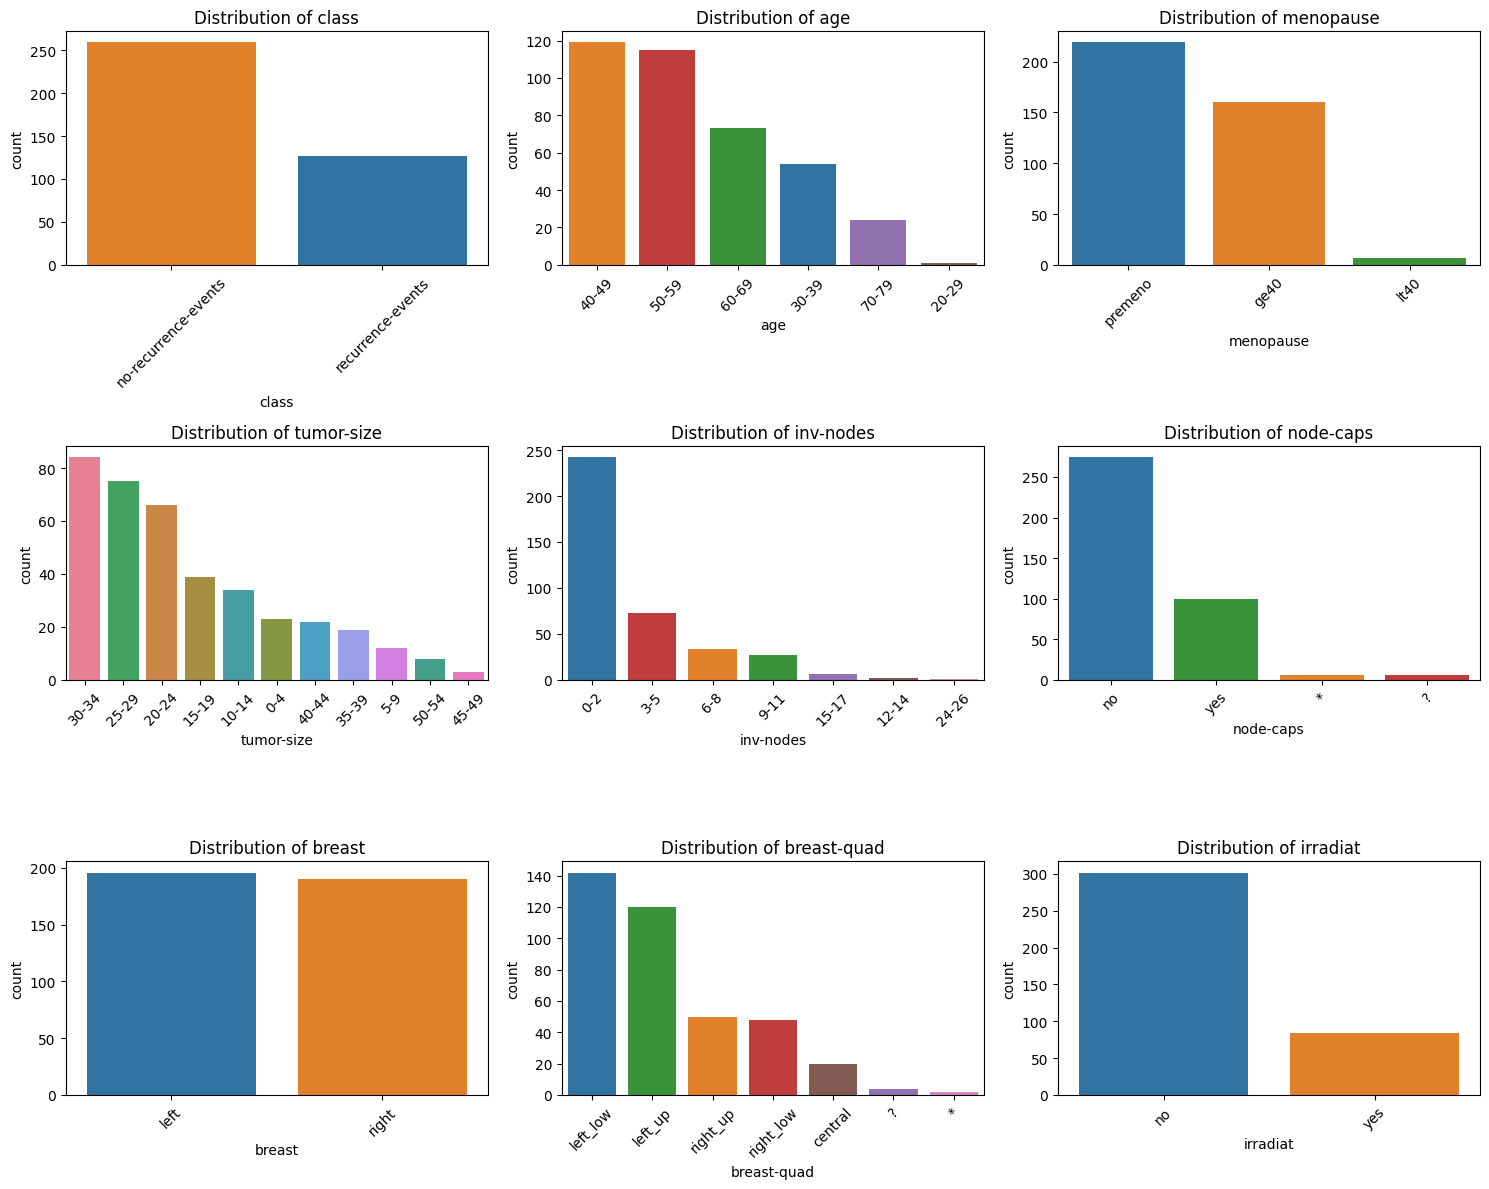

In [12]:
# visualize categorical variables
categorical_cols = ["class", "age", "menopause", "tumor-size", "inv-nodes",
                    "node-caps", "breast", "breast-quad", "irradiat"]

# create subplots
plt.figure(figsize=(15, 12))
for i, col in enumerate(categorical_cols):
    plt.subplot(3, 3, i + 1)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, hue=col, dodge=False, legend=False) # Update here
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

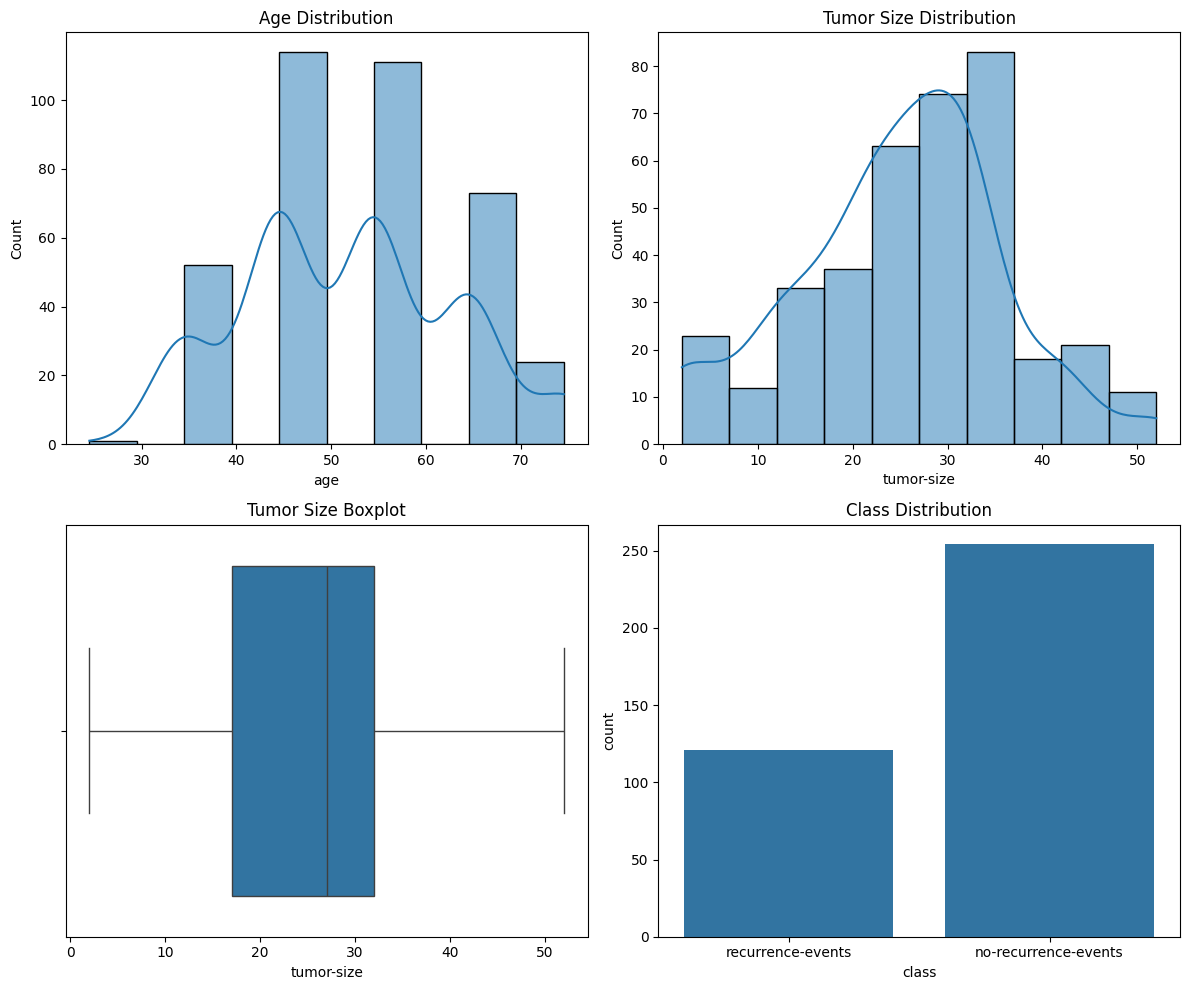

In [13]:
# univariate analysis
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# age histogram
sns.histplot(df_cleaned["age"], bins=10, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Age Distribution")

# tumor size histogram
sns.histplot(df_cleaned["tumor-size"], bins=10, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Tumor Size Distribution")

# tumor size boxplot
sns.boxplot(x=df_cleaned["tumor-size"], ax=axes[1, 0])
axes[1, 0].set_title("Tumor Size Boxplot")

# class countplot (target var)
sns.countplot(x=df_cleaned["class"], ax=axes[1, 1])
axes[1, 1].set_title("Class Distribution")

# show plots
plt.tight_layout()
plt.show()

Key Observations from Univariate Analysis

* Age Distribution
  *   The majority of patients fall in the 40-60 year age range.
  *   The distribution is slightly right-skewed, meaning more patients are in older age groups.

* Tumor Size Distribution
  *   The tumor size values follow a right-skewed distribution, meaning smaller tumors are more common.
  *   Kernel Density Estimation (KDE) curve shows a peak around mid-range tumor sizes.

* Tumor Size Boxplot
  *   There are potential outliers in tumor size (larger tumors beyond the usual range).
  *   The median tumor size is relatively small.

* Class Distribution
  *   Class imbalance is present, with "no-recurrence-events" cases being more frequent than "recurrence-events."


In [10]:
# one-hot encoding on categorical variables
df_encoded = pd.get_dummies(df_cleaned, columns=["menopause", "node-caps", "breast", "breast-quad", "irradiat"], drop_first=True)

print(df_encoded.head())

                  class   age tumor-size inv-nodes  deg-malig  menopause_lt40  \
0     recurrence-events  34.5       32.0       1.0          3           False   
1  no-recurrence-events  44.5       22.0       1.0          2           False   
2     recurrence-events  44.5       22.0       1.0          2           False   
3  no-recurrence-events  64.5       17.0       1.0          2           False   
4  no-recurrence-events  44.5        2.0       1.0          2           False   

   menopause_premeno  node-caps_yes  breast_right  breast-quad_left_low  \
0               True          False         False                  True   
1               True          False          True                 False   
2               True          False         False                  True   
3              False          False          True                 False   
4               True          False          True                 False   

   breast-quad_left_up  breast-quad_right_low  breast-quad_rig

## Part 2